# Using VAR, VARMA and VARMAX models to predict USA macroeconomic variables

## 0. Imports

### 0.1. Libraries

In [1]:
# Data Manipulation
import  pandas               as pd
import  numpy                as np
import  statsmodels.api      as sm

# Visualization
import  matplotlib           as mpl
import  matplotlib.pyplot    as plt
import  seaborn              as sns

# Statsmodels
from    statsmodels.graphics.tsaplots       import plot_acf, plot_pacf
from    statsmodels.tsa.stattools           import adfuller, grangercausalitytests
from    statsmodels.tsa.statespace.varmax   import VARMAX

# Other
import  warnings
from    itertools            import product
from    tqdm                 import tqdm_notebook

### 0.2. Settings

In [2]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Pandas Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Visualization Settings
%matplotlib inline

# Set a style
mpl.style.use('ggplot')

# Customize rcParams
mpl.rcParams.update({
    'figure.titlesize': 24,
    'figure.figsize': (18, 6),
    'figure.dpi': 250,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'axes.facecolor': 'white',
    'axes.linewidth': 1,
    'axes.grid': True,
    'xtick.labelsize': 12,
    'xtick.color': 'black',
    'xtick.bottom': False,
    'ytick.labelsize': 12,
    'ytick.color': 'black',
    'ytick.left': False,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.color': 'lightgray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})

### 0.3. Functions

In [3]:
# Set Plot Configuration

def set_plot(fig, title, xlabel, ylabel):
    """
    Summary: This function sets the plot configuration for the initial plots. 
    Args:
        fig:    the figure object.
        title:  the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
    Returns: figure with the image configuration.
    """
    # Customizing
    fig.set_title(title)
    fig.set_xlabel(xlabel, color='black')
    fig.set_ylabel(ylabel, color='black')
    fig.tick_params(left=False, bottom=False)

    return fig

# Printing ADF Test Results
def print_adf_result(result):
    print('Augmented Dickey-Fuller Test Results')
    print('------------------------------------')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'No. of lags used: {result[2]}')
    print(f'No. of observations used: {result[3]}')
    print('Critical Values:')

    for key, value in result[4].items():
        print(f'   {key}: {value}')

# VAR Model

def optimize_VAR(endog):
    """
    Summary: This function performs the optimization process for the VAR model. 
    Args:
        endog: the endogenous variable.
    Returns: the optimal order for the VAR model.
    """
    # Create empty lists to store the results
    results = []

    for i in tqdm_notebook(range(15)):
        try:
            # Fit the model considereing only the AR process of the model by forcing q to be zero
            model = VARMAX(endog, order=(i, 0)).fit(dips=False) 
        except:
            continue

        # Store the results
        mse = model.mse
        aic = model.aic
        results.append([i, mse, aic])

    result_df = pd.DataFrame(results, columns=['p', 'mse', 'aic'])
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)

    return result_df

# VARMA Model

def optimize_VARMA(endog, parameters_list):
    """
    Summary: This function performs the optimization process for the VARMA model.
    Args:
        endog: the observed variable.
        parameters_list: list of (p, q) tuples.
    Returns: a DataFrame with the optimal order for the VARMA model.
    """
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=(param[0], param[1])).fit(disp=False)
        except:
            continue

        mse = model.mse
        aic = model.aic
        results.append([param, mse, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'mse', 'aic']

    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)

    return result_df

# VARMAX Model

def optimize_VARMAX(endog, exog, parameters_list):
    """
    Summary: This function performs the optimization process for the VARMAX model.
    Args:
        endog: the observed variable.
        exog: the exogenous variable.
        parameters_list: list of (p, q) tuples.
    Returns: a DataFrame with the optimal order for the VARMA model.
    """
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=(param[0], param[1])).fit(disp=False)
        except:
            continue

        mse = model.mse
        aic = model.aic
        results.append([param, mse, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'mse', 'aic']

    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)

    return result_df


### 0.4. United States Macroeconomic Dataset

In [4]:
macro_data = sm.datasets.macrodata.load_pandas().data

In [5]:
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.00,1.00,2710.35,1707.40,286.90,470.05,1886.90,28.98,139.70,2.82,5.80,177.15,0.00,0.00
1,1959.00,2.00,2778.80,1733.70,310.86,481.30,1919.70,29.15,141.70,3.08,5.10,177.83,2.34,0.74
2,1959.00,3.00,2775.49,1751.80,289.23,491.26,1916.40,29.35,140.50,3.82,5.30,178.66,2.74,1.09
3,1959.00,4.00,2785.20,1753.70,299.36,484.05,1931.30,29.37,140.00,4.33,5.60,179.39,0.27,4.06
4,1960.00,1.00,2847.70,1770.50,331.72,462.20,1955.50,29.54,139.60,3.50,5.20,180.01,2.31,1.19


<Axes: title={'center': 'Real Consumption'}, xlabel='Year', ylabel='Real Consumption'>

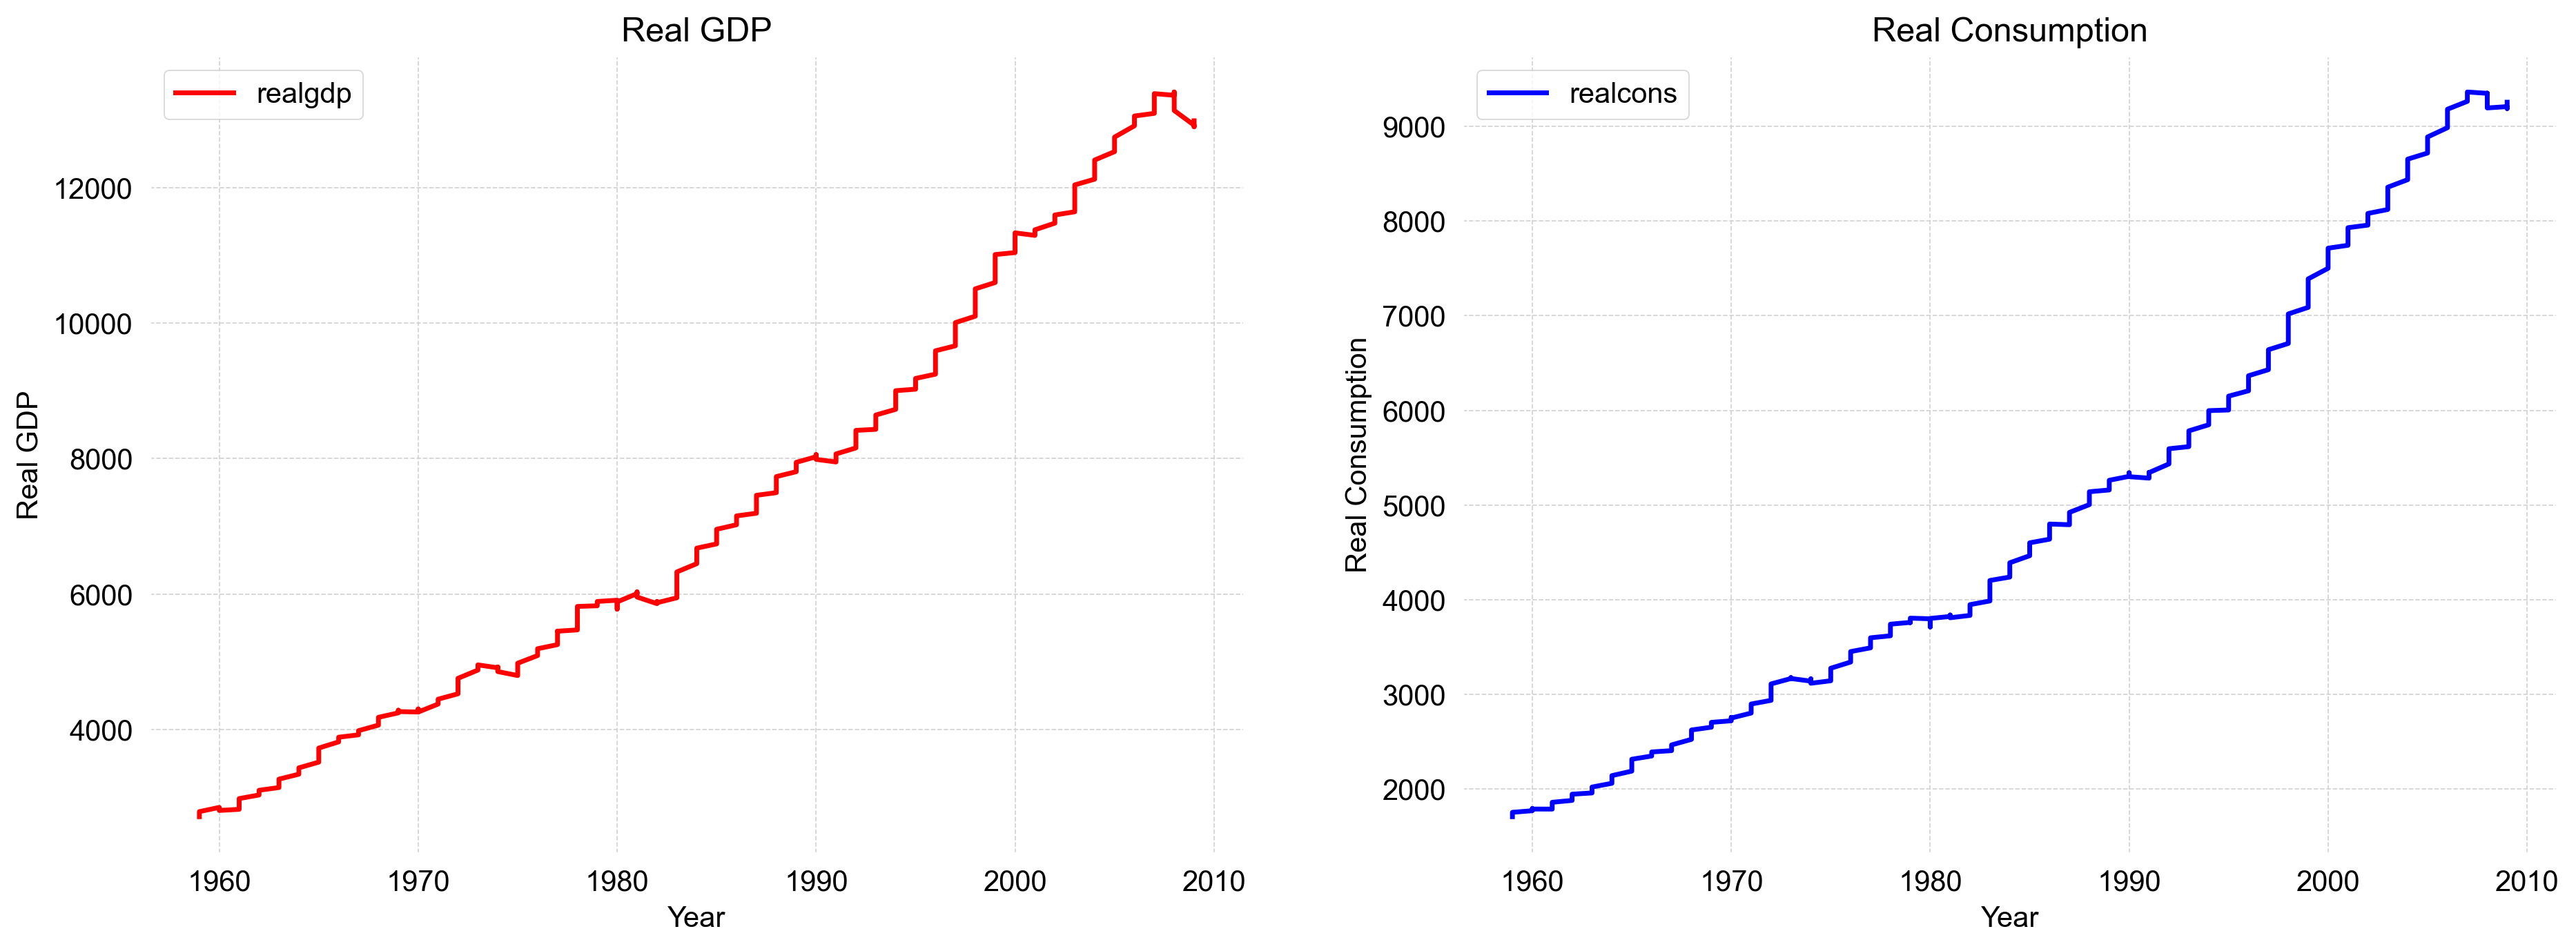

In [6]:
# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Real GDP
macro_data.plot(x='year', y='realgdp', color='red', ax=ax1)
set_plot(ax1, 'Real GDP', 'Year', 'Real GDP')

# Real Consumption
macro_data.plot(x='year', y='realcons', color='blue', ax=ax2)
set_plot(ax2, 'Real Consumption', 'Year', 'Real Consumption')

## 1. Augmented Dickey-Fuller Test

In [7]:
# Augmented Dickey-Fuller Test for differenced Real GDP
ad_fuller_result_1 = adfuller(macro_data['realgdp'].diff().dropna())

# Results
print_adf_result(ad_fuller_result_1)

Augmented Dickey-Fuller Test Results
------------------------------------
ADF Statistic: -6.305695561658104
p-value: 3.327882187668259e-08
No. of lags used: 1
No. of observations used: 200
Critical Values:
   1%: -3.463476079125
   5%: -2.876102355
   10%: -2.574532225


In [8]:
# Augmented Dickey-Fuller Test for differenced Real Consumption
ad_fuller_result_2 = adfuller(macro_data['realcons'].diff().dropna())

# Results
print_adf_result(ad_fuller_result_2)

Augmented Dickey-Fuller Test Results
------------------------------------
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571
No. of lags used: 3
No. of observations used: 198
Critical Values:
   1%: -3.4638151713286316
   5%: -2.876250632135043
   10%: -2.574611347821651


## 2. VAR Model

In [9]:
# Endogenous variables
endog = macro_data[['realgdp', 'realcons']]

# Optimize VAR Model
result_df = optimize_VAR(endog)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,mse,aic
0,13,140293.23,4071.12
1,12,141264.28,4073.42
2,11,148003.65,4069.48
3,10,156625.27,4066.71
4,9,161333.38,4066.30
5,8,162039.06,4062.22
6,6,173102.03,4051.06
7,5,183139.96,4045.58
8,4,193390.55,4037.50
9,3,374832.46,4059.71


In [10]:
# Calculating best model based on previous result
best_model = VARMAX(endog, order=(13, 0))

res_VAR = best_model.fit(dips=False)

# Printing best model result
print(res_VAR.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(13)   Log Likelihood               -1978.560
                               + intercept   AIC                           4071.120
Date:                     Wed, 18 Sep 2024   BIC                           4259.973
Time:                             18:17:13   HQIC                          4147.522
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):           4.88, 5.19
Prob(Q):                        0.96, 0.95   Prob(JB):                   0.09, 0.07
Heteroskedasticity (H):         1.74, 2.56   Skew:                       0.3

### 2.1.VAR Residuals

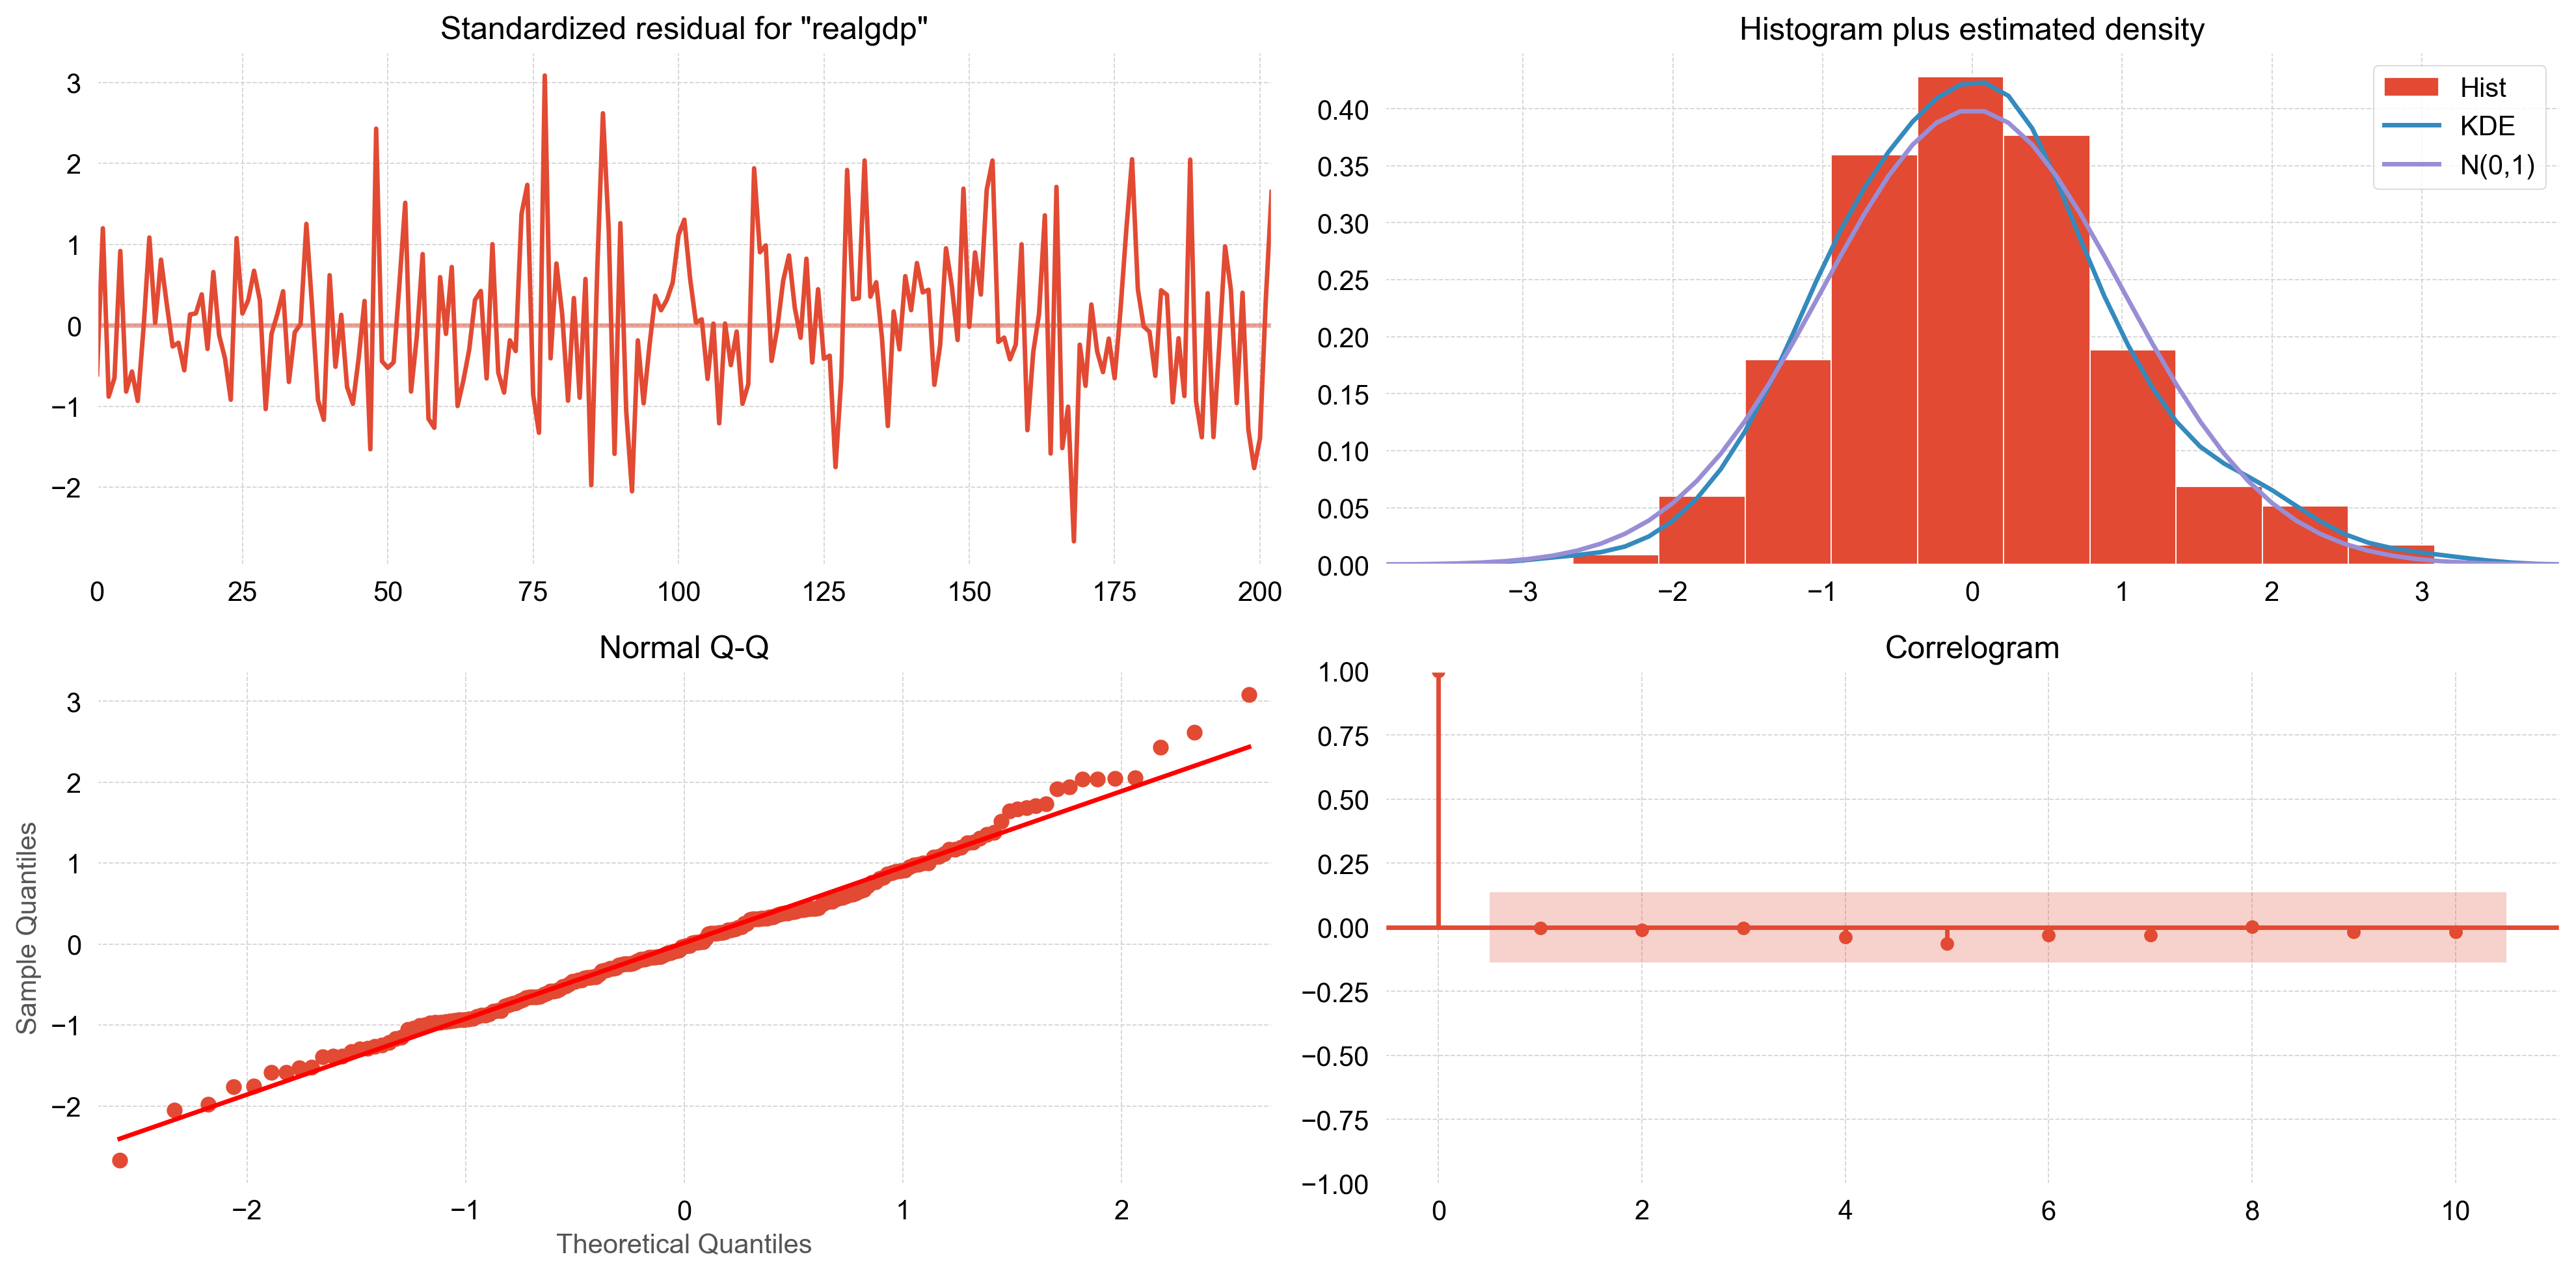

In [11]:
# Residuals diagnostics
fig = res_VAR.plot_diagnostics()

# Customize
fig.set_size_inches(16, 8)
plt.tight_layout()

- Histogram distribution of residuals is fairly close to normality distribution.
- Very little deviation from normality in the Q-Q plot, only at the end.
- No significant coefficients after lag zero in the correlogram.
- These points indicate that the residuals are close to a Gaussian distribution.
- Thus, we can use this model to make predictions.

### 2.2. VAR Predictions

In [12]:
# Set forecast horizon
n_forecast = 3

# Prediction
predict = res_VAR.get_prediction(end=best_model.nobs + n_forecast)

# Index
idx = np.arange(len(predict.predicted_mean))

# Predicted values
predict.predicted_mean.tail(3)

,realgdp,realcons
204,13165.58,9323.23
205,13199.01,9321.77
206,13233.74,9331.02


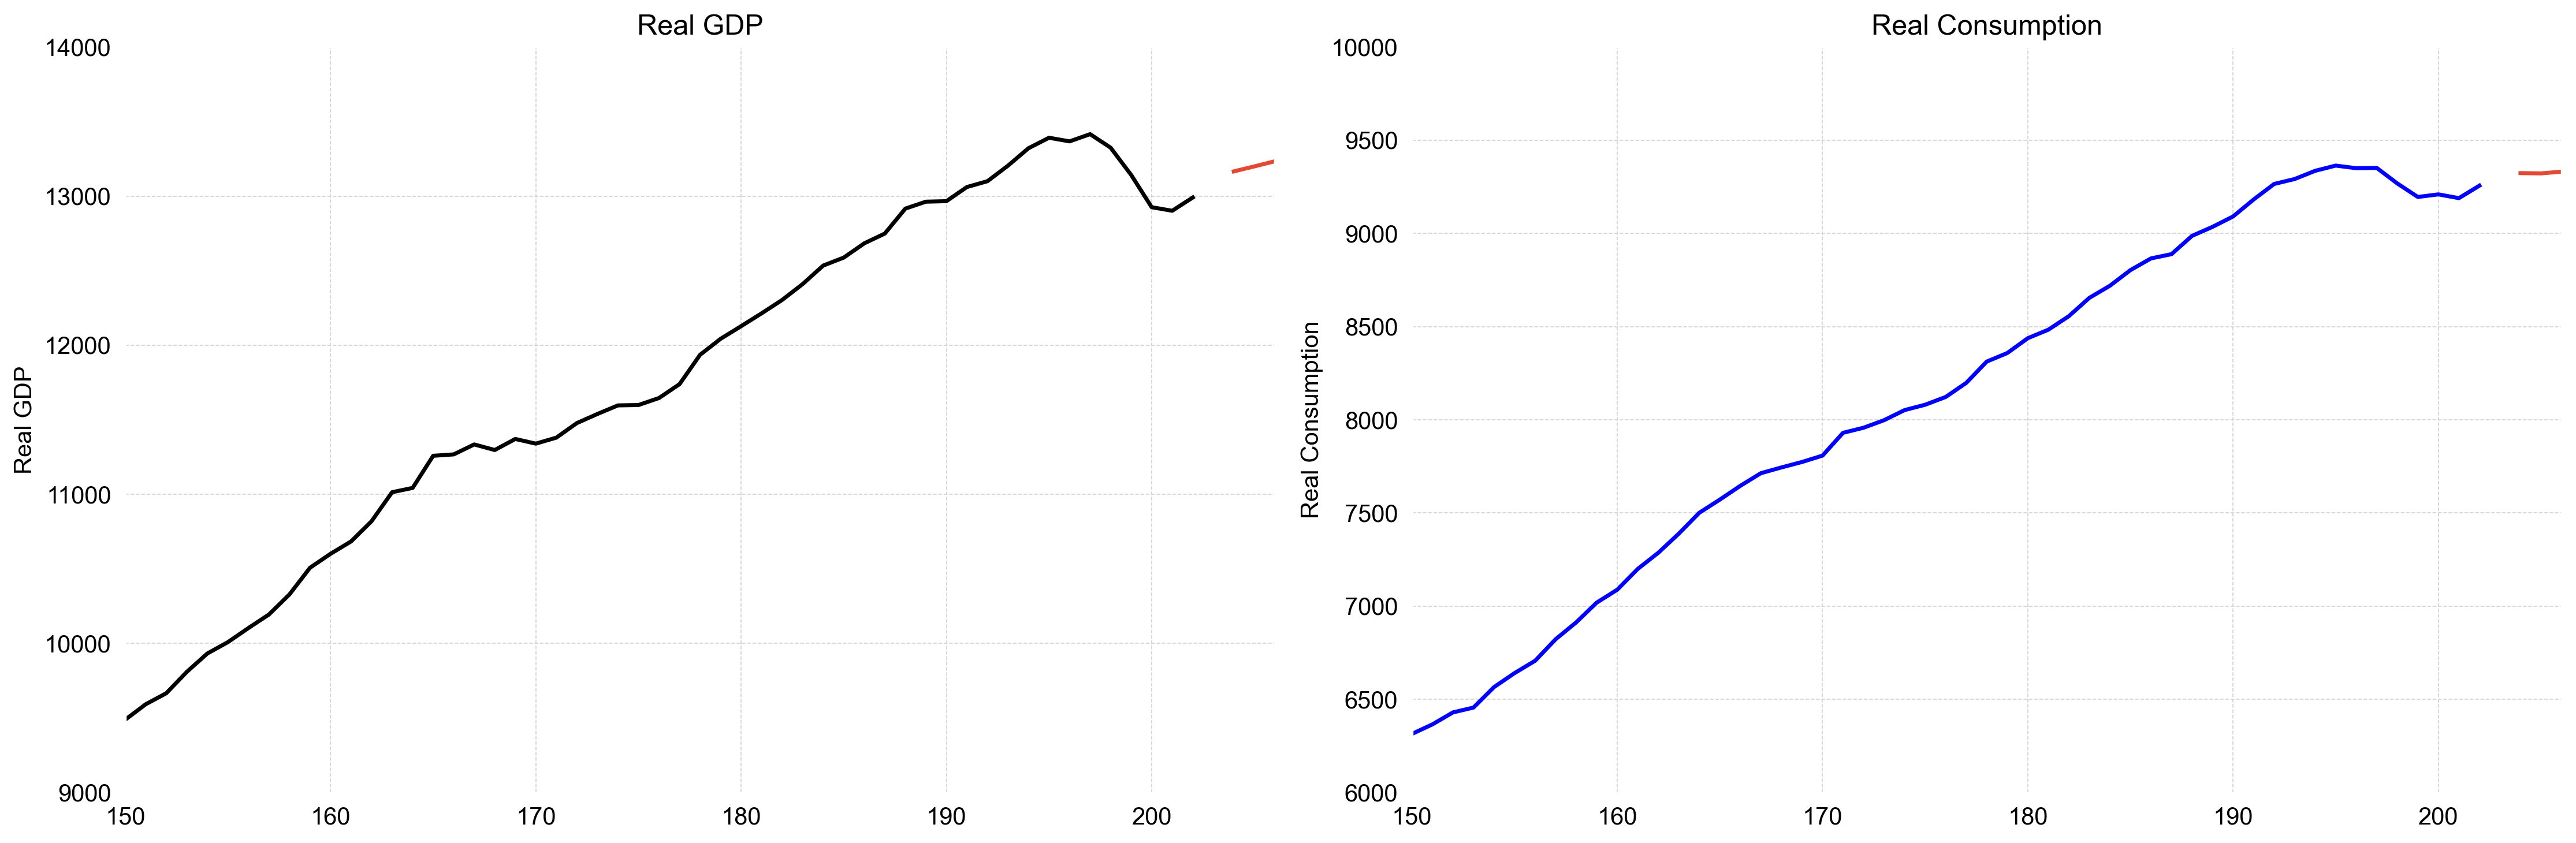

In [13]:
# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Real GDP
ax1.plot(macro_data['realgdp'], color='black')
ax1.plot(idx[-n_forecast:], predict.predicted_mean['realgdp'][-n_forecast:])
set_plot(ax1, 'Real GDP', None, 'Real GDP')

# Axes limits
ax1.set_xlim(150, 206)
ax1.set_ylim(9000, 14000)

# Real Consumption
ax2.plot(macro_data['realcons'], color='blue')
ax2.plot(idx[-n_forecast:], predict.predicted_mean['realcons'][-n_forecast:])
set_plot(ax2, 'Real Consumption', None, 'Real Consumption')

# Axes limits
ax2.set_xlim(150, 206)
ax2.set_ylim(6000, 10000)

plt.tight_layout()

## 3. Granger Causality Test
- VAR assumes that both variables are causing each other.
- In other words, `realgdp` and `realcons` can be used to predict each other as well.
- The Granger Causality Test null hypothesis states that the variable `realgdp` is not caused by `realcons` and vice versa.
- A *p*-value of less than 0.05 indicates that we can reject the null hypothesis and conclude that the variables are Granger-causal.
- So a change in `realgdp` can cause a change in `realcons` and vice-versa.

Does `realcons` cause `realgdp`?

In [14]:
# The second column is what causes the first column
granger_1 = grangercausalitytests(
            macro_data[['realgdp', 'realcons']].diff().dropna(), [13])


Granger Causality
number of lags (no zero) 13
ssr based F test:         F=5.6420  , p=0.0000  , df_denom=162, df_num=13
ssr based chi2 test:   chi2=85.5708 , p=0.0000  , df=13
likelihood ratio test: chi2=70.5844 , p=0.0000  , df=13
parameter F test:         F=5.6420  , p=0.0000  , df_denom=162, df_num=13


- The *p*-value is less than 0.05, so we can reject the null hypothesis and conclude that `realcons` Granger-causes `realgdp`.

Does `realgdp` cause `realcons`?

In [15]:
granger_2 = grangercausalitytests(
            macro_data[['realcons', 'realgdp']].diff().dropna(), [13])


Granger Causality
number of lags (no zero) 13
ssr based F test:         F=2.1361  , p=0.0146  , df_denom=162, df_num=13
ssr based chi2 test:   chi2=32.3973 , p=0.0021  , df=13
likelihood ratio test: chi2=29.9021 , p=0.0049  , df=13
parameter F test:         F=2.1361  , p=0.0146  , df_denom=162, df_num=13


- The *p*-value is less than 0.05, so we can reject the null hypothesis and conclude that `realgdp` Granger-causes `realcons`.

---

## 4. VARMA Model

In [16]:
endog = macro_data[['realgdp', 'realcons']]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters_list = list(product(p, q))

result_df_VARMA = optimize_VARMA(endog, parameters_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",mse,aic
0,"(3, 2)",164113.53,4050.82
1,"(3, 1)",171955.53,4043.97
2,"(3, 3)",267914.45,4054.79
3,"(1, 1)",293411.73,5892.46
4,"(3, 0)",374832.46,4059.71
5,"(0, 1)",553891.39,6149.96
6,"(1, 2)",656881.33,19299.24
7,"(2, 1)",754591.01,29301.13
8,"(0, 3)",868066.79,6070.14
9,"(2, 2)",1285073.54,9033.55


In [17]:
best_model_VARMA = VARMAX(endog, order=(3, 2))

res_VARMA = best_model_VARMA.fit(disp=False)

print(res_VARMA.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                          VARMA(3,2)   Log Likelihood               -2000.412
                               + intercept   AIC                           4050.824
Date:                     Wed, 18 Sep 2024   BIC                           4133.654
Time:                             18:17:53   HQIC                          4084.333
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.12, 0.11   Jarque-Bera (JB):           3.14, 6.68
Prob(Q):                        0.73, 0.75   Prob(JB):                   0.21, 0.04
Heteroskedasticity (H):         2.43, 3.00   Skew:                       0.1

### 4.1. VARMA Residuals

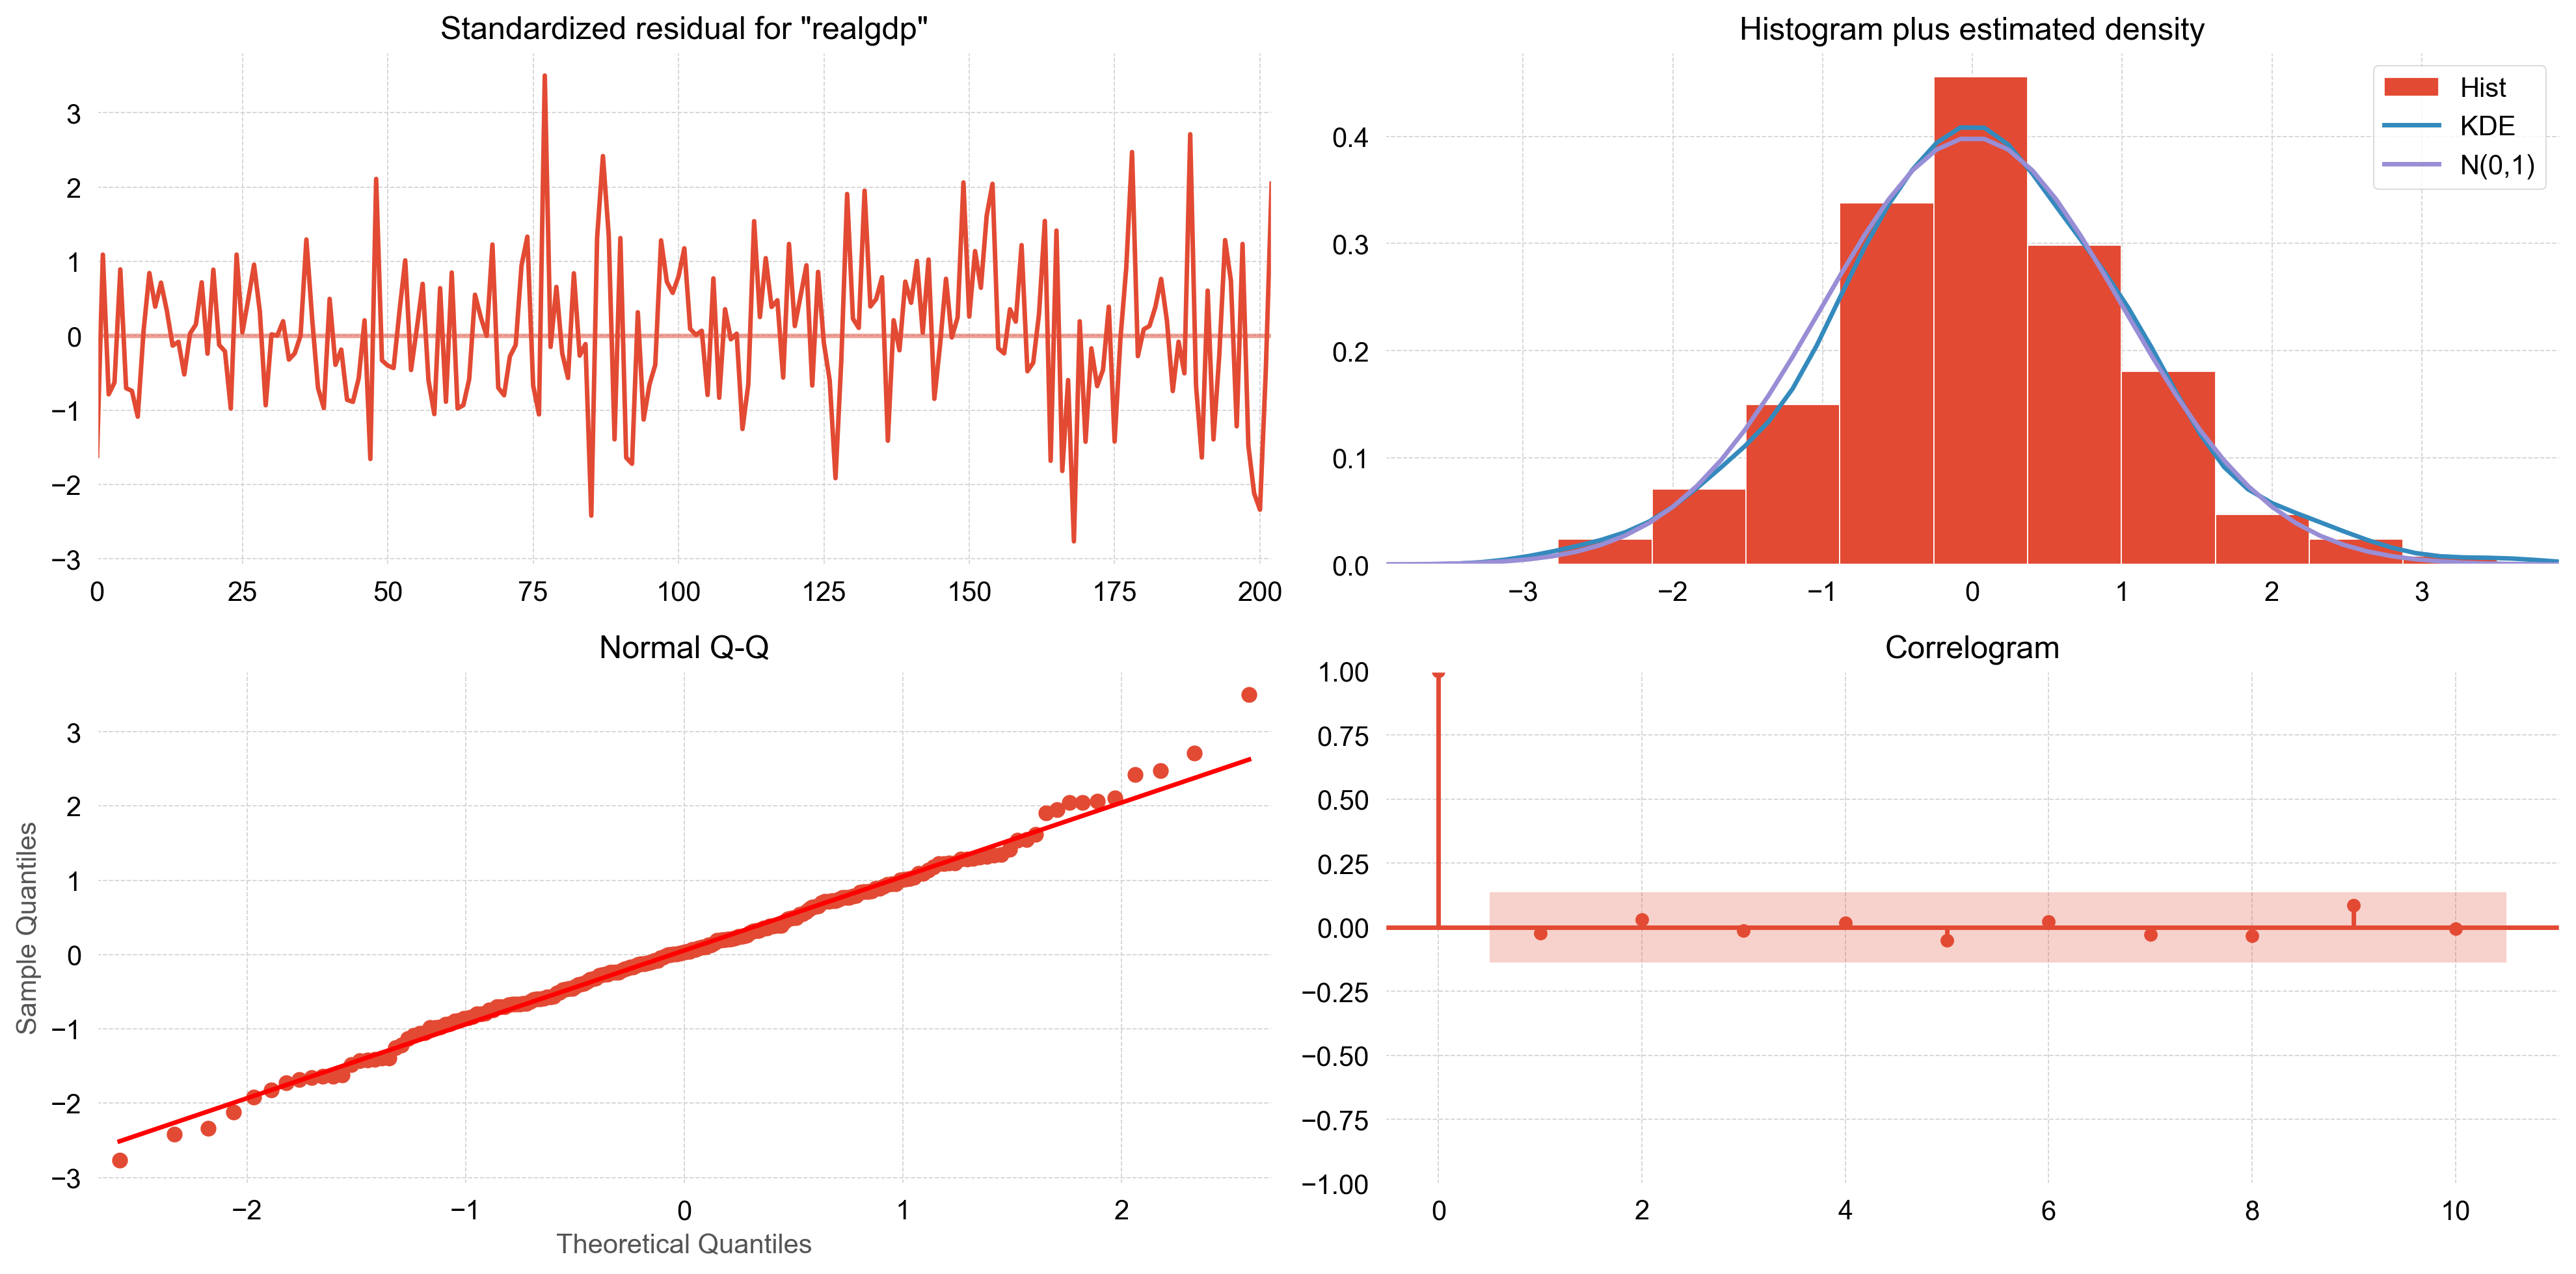

In [18]:
res_VARMA.plot_diagnostics(figsize=(16, 8))

plt.tight_layout()

### 4.2. VARMA Predictions

In [19]:
# Set forecast horizon
n_forecast = 3

# Prediction
predict = res_VARMA.get_prediction(end=best_model_VARMA.nobs + n_forecast)

# Index
idx = np.arange(len(predict.predicted_mean))

# Predicted values
predict.predicted_mean.tail(3)

,realgdp,realcons
204,13069.86,9286.73
205,13076.18,9302.43
206,13095.97,9303.13


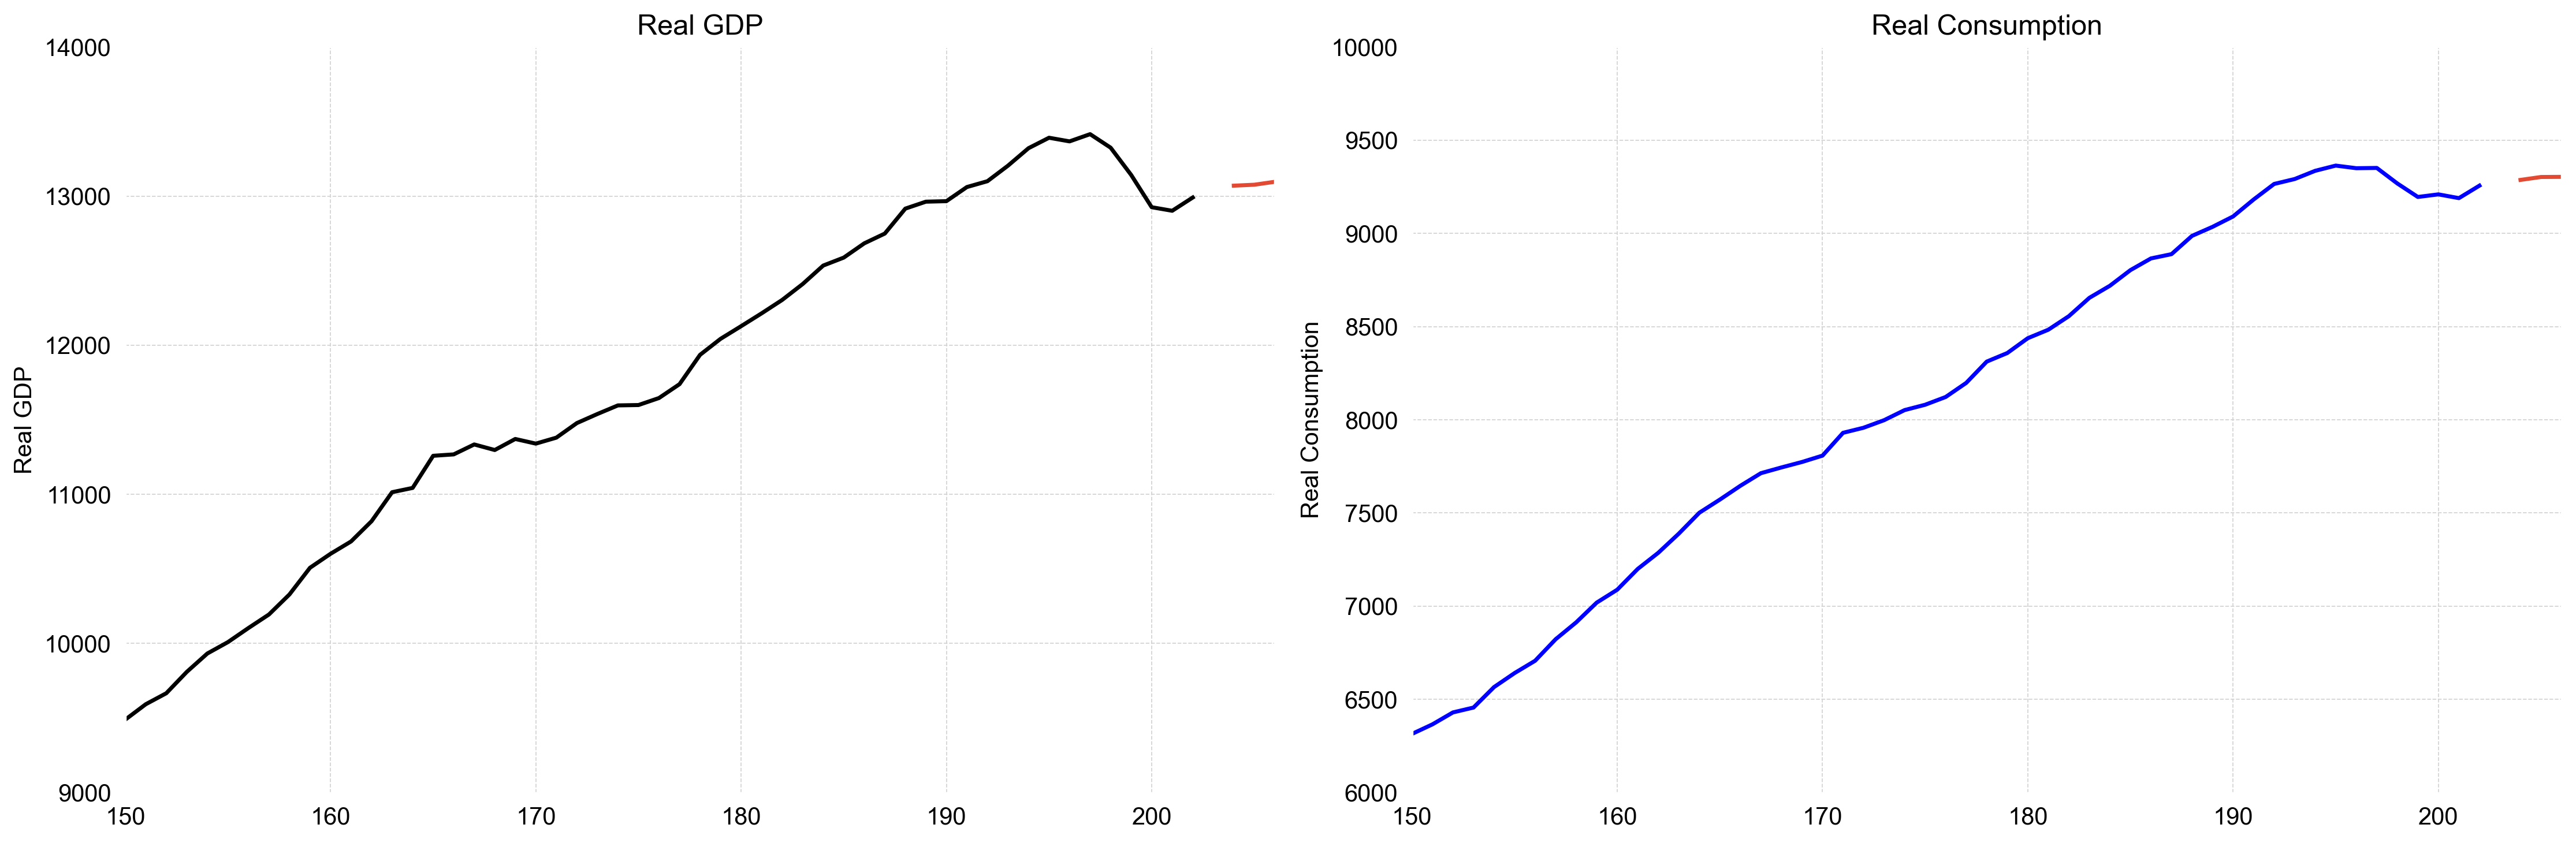

In [20]:
# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Real GDP
ax1.plot(macro_data['realgdp'], color='black')
ax1.plot(idx[-n_forecast:], predict.predicted_mean['realgdp'][-n_forecast:])
set_plot(ax1, 'Real GDP', None, 'Real GDP')

# Axes limits
ax1.set_xlim(150, 206)
ax1.set_ylim(9000, 14000)

# Real Consumption
ax2.plot(macro_data['realcons'], color='blue')
ax2.plot(idx[-n_forecast:], predict.predicted_mean['realcons'][-n_forecast:])
set_plot(ax2, 'Real Consumption', None, 'Real Consumption')

# Axes limits
ax2.set_xlim(150, 206)
ax2.set_ylim(6000, 10000)

plt.tight_layout()

---

## 5. VARMAX Model

In [21]:
endog = macro_data[['realgdp', 'realcons']][:200]

exog_cols = macro_data.columns.drop(['year', 'quarter', 'realgdp', 'realcons'])

exog = macro_data[exog_cols][:200]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters_list = list(product(p, q))

result_df_VARMAX = optimize_VARMAX(endog, exog, parameters_list)

result_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",mse,aic
0,"(3, 3)",2322.60,4001.71
1,"(1, 3)",2337.72,3988.93
2,"(2, 3)",2342.56,3985.96
3,"(3, 2)",2359.00,3995.85
4,"(2, 2)",2395.33,3984.76
5,"(1, 2)",2404.99,3984.56
6,"(3, 1)",2465.10,4000.78
7,"(3, 0)",2519.68,4000.98
8,"(2, 1)",2539.54,3994.49
9,"(1, 0)",2559.29,4001.84


In [22]:
best_model_VARMAX = VARMAX(endog, exog, order=(3, 3))

res_VARMAX = best_model_VARMAX.fit(disp=False)

print(res_VARMAX.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  200
Model:                         VARMAX(3,3)   Log Likelihood               -1951.856
                               + intercept   AIC                           4001.713
Date:                     Wed, 18 Sep 2024   BIC                           4163.330
Time:                             18:19:26   HQIC                          4067.117
Sample:                                  0                                         
                                     - 200                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             1.04, 0.12   Jarque-Bera (JB):           4.20, 3.52
Prob(Q):                        0.31, 0.73   Prob(JB):                   0.12, 0.17
Heteroskedasticity (H):         1.84, 2.25   Skew:                      0.06

### 5.1. VARMAX Residuals

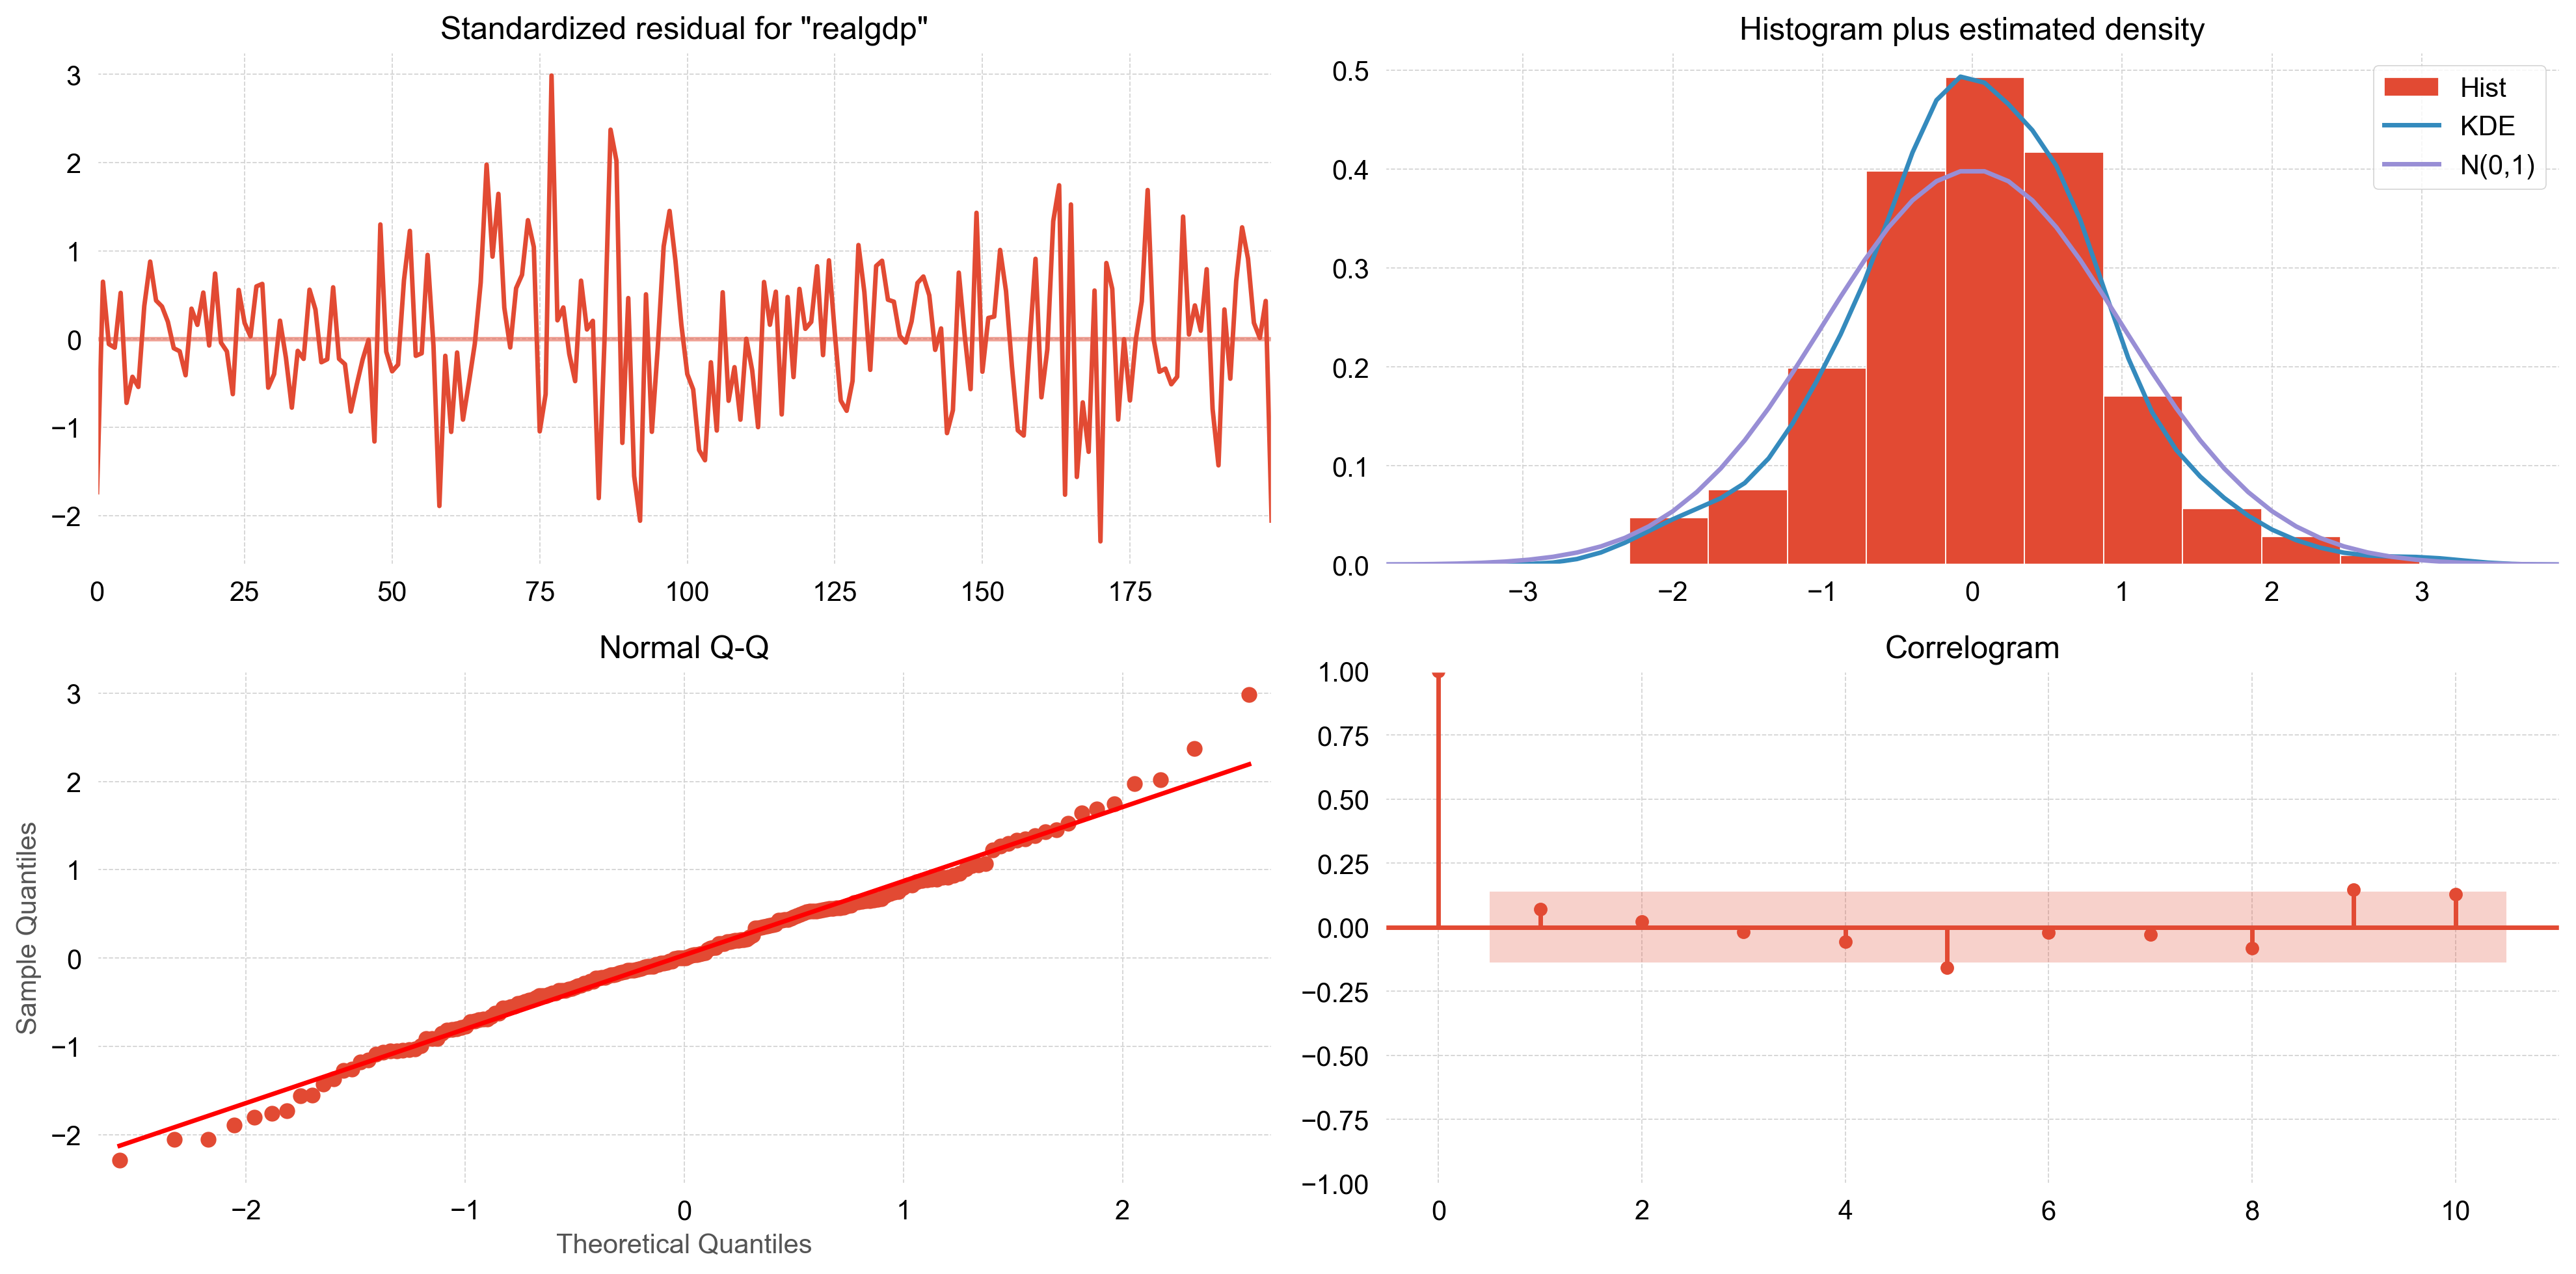

In [23]:
fig = res_VARMAX.plot_diagnostics(figsize=(16, 8))

plt.tight_layout()

### 5.2. VARMAX Predictions

In [24]:
# Set forecast horizon
n_forecast = 3

# Prediction
predict = res_VARMAX.get_prediction(
            end=best_model_VARMAX.nobs + n_forecast,
            exog=exog.iloc[-4:])

# Index
idx = np.arange(len(predict.predicted_mean))

# Predicted values
predict.predicted_mean.tail(3)

,realgdp,realcons
201,13226.53,9304.01
202,13188.11,9257.12
203,13153.24,9269.27


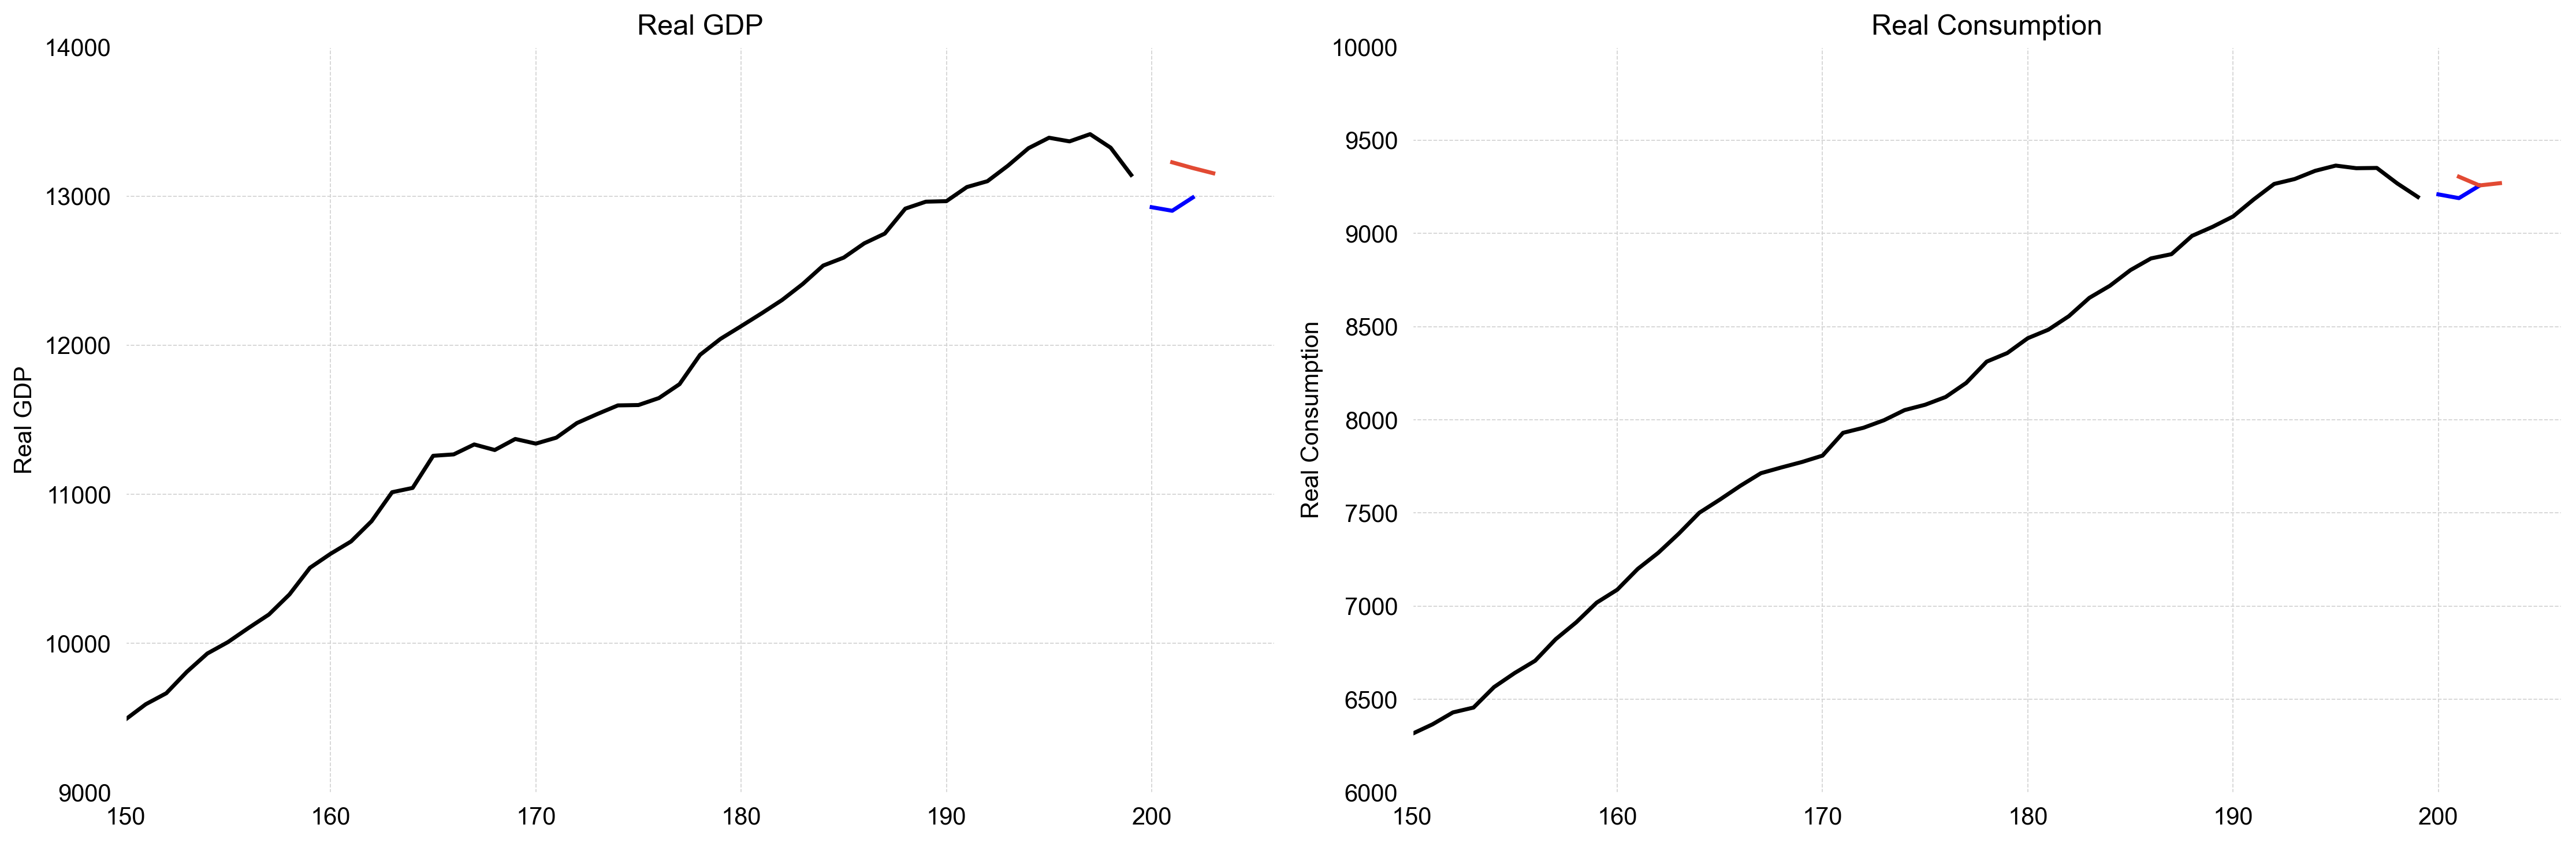

In [25]:
# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Real GDP
ax1.plot(macro_data['realgdp'][:200], color='black')
ax1.plot(macro_data['realgdp'][200:], color='blue')
ax1.plot(idx[-n_forecast:], predict.predicted_mean['realgdp'][-n_forecast:])
set_plot(ax1, 'Real GDP', None, 'Real GDP')

# Axes limits
ax1.set_xlim(150, 206)
ax1.set_ylim(9000, 14000)

# Real Consumption
ax2.plot(macro_data['realcons'][:200], color='black')
ax2.plot(macro_data['realcons'][200:], color='blue')
ax2.plot(idx[-n_forecast:], predict.predicted_mean['realcons'][-n_forecast:])
set_plot(ax2, 'Real Consumption', None, 'Real Consumption')

# Axes limits
ax2.set_xlim(150, 206)
ax2.set_ylim(6000, 10000)

plt.tight_layout()